In [7]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
from geoalchemy2 import Geometry, WKTElement

# Data Cleaning and Uploading Data to pgAdmin

In the section below, we are cleaning all our files including:
1.  Neighbourhoods.csv
2.  BusinessStats.csv
3.  StatisticalAreas.csv
4.  RFSNSW_BFPL.shp
5.  SA2_2016_AUST.shp
6.  RFSStation_EPSG4326.json (additional dataset)

Methods for cleaning data includes:

- checkNull(dataset, beenCleaned): check if there's a null value
- removeNull(dataset): drop the null value in the dataset

** For each dataset, we also check the type of different columns to see if they are in their correct type. If they're not, then we convert them. For instance, all population values are intially string, but we convert them into numeric values.


In [8]:
# Function use to check if null values exist in the dataset. If there's null value, we'll drop the row to increase 
# accuracy in our calculations.

def checkNull( dataset ):
    
    beenCleaned = False    
    
    for num in list(dataset.isnull().sum()):

        if num != 0:
            print("Null value found. Coverted null values to ...")
            dataset = dataset.dropna() #found null, drop the row
            beenCleaned = True
            
    if beenCleaned:
        print("\nNull values have been removed. You're good to go!")

    else:
        print("\nNo null values in. Good to go, no need for cleaning :)")

    return dataset

## Cleaning StatisticalAreas.csv and Uploading it

In [9]:
rawData = pd.read_csv("StatisticalAreas.csv")

#Check if contains NULL
cleanData = checkNull(rawData)

#Cleaning data so that only numeric values are included in area_id
if cleanData['area_id'].dtypes != int:
    print("\nUpdated area_id data type from " + str(cleanData['area_id'].dtypes) + " to integer & removed data with wrong type")
    cleanData = cleanData[cleanData.area_id.str.isnumeric()]
    cleanData['area_id'].astype(int)

#Cleaning data so that only numeric values are included in parent_area_id
if cleanData['parent_area_id'].dtypes != int:
    print("\nUpdated area_id data type from " + str(cleanData['parent_area_id'].dtypes) + " to integer & removed data with wrong type")
    cleanData = cleanData[cleanData.parent_area_id.str.isnumeric()]
    cleanData['parent_area_id'].astype(int)

statisticalAreas_clean = cleanData


statisticalAreas = statisticalAreas_clean

statisticalAreas.head(2)


No null values in. Good to go, no need for cleaning :)


,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1


## Cleaning and Uploading Neighbourhoods.csv

In [10]:
rawData = pd.read_csv("Neighbourhoods.csv")
#Check if there's null values

noNull_data = checkNull(rawData)
neighbourhoods_clean = noNull_data.copy()
numericData = ['area_id', 'land_area', 'population', 'number_of_dwellings', 'number_of_dwellings', 
               'number_of_businesses', 'median_annual_household_income', 'avg_monthly_rent']

for col in noNull_data.columns:
    
    if col in numericData:        
        if noNull_data[col].dtypes != int and noNull_data[col].dtypes != float:
            neighbourhoods_clean[col] = noNull_data[col].str.replace(',', '')
            neighbourhoods_clean[col] = pd.to_numeric(neighbourhoods_clean[col])   
            
print ("\nCommas in numeric data removed and all numbers as type string converted to numeric values!")

neighbourhoods = neighbourhoods_clean


Null value found. Coverted null values to ...
Null value found. Coverted null values to ...
Null value found. Coverted null values to ...
Null value found. Coverted null values to ...

Null values have been removed. You're good to go!

Commas in numeric data removed and all numbers as type string converted to numeric values!


## Cleaning and Uploading BusinessStats.csv


In [11]:
rawData = pd.read_csv("BusinessStats.csv")

#Remove null values
noNull_data = checkNull(rawData)
businesStats_clean = noNull_data.copy()

numericData = ['area_id', 'number_of_businesses', 'accommodation_and_food_services', 'retail_trade', 'agriculture_forestry_and_fishing', 
               'health_care_and_social_assistance', 'public_administration_and_safety', 'transport_postal_and_warehousing']

for col in noNull_data.columns:
    
    if col in numericData:        
        if noNull_data[col].dtypes != int and noNull_data[col].dtypes != float:
            businesStats_clean[col] = noNull_data[col].str.replace(',', '')
            businesStats_clean[col] = pd.to_numeric(businesStats_clean[col])   

            
print ("\nCommas in numeric data removed and all numbers as type string converted to numeric values!")

businessStats = businesStats_clean


No null values in. Good to go, no need for cleaning :)

Commas in numeric data removed and all numbers as type string converted to numeric values!


## Cleaning and Uploading RFSNSW_BFPL

In [12]:
abs_pathname = os.path.abspath("RFSNSW_BFPL.shp")
rfs_shapefile = gpd.read_file(abs_pathname)
rfs_shapefile = checkNull(rfs_shapefile)
rfs_dataframe = pd.DataFrame(data = rfs_shapefile)

rfs_shapefile.head(2)



No null values in. Good to go, no need for cleaning :)


,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000017,5.392400e-12,POINT (149.11319 -33.05824)
1,1,0.000178,1.140005e-09,POINT (152.27536 -29.68316)


## Cleaning and Uploading SA2_2016_AUST

In [13]:
abs_pathname = os.path.abspath("SA2_2016_AUST.shp")
sa_2_shapefile = gpd.read_file(abs_pathname)
sa_2_shapefile = checkNull(sa_2_shapefile)

sa_2_shapefile.head(2)
# print(sa_2_shapefile.dtypes)


Null value found. Coverted null values to ...

Null values have been removed. You're good to go!


,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."


## Cleaning and Uploading Additional Data Set

No Null Coordinates in this file. You're good to go!


<AxesSubplot:>

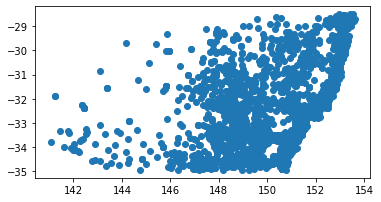

In [16]:
#Reading the json file
import json
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

with open('RFSStation_EPSG4326.json') as f:
  fire_stations = json.load(f)
f.close()


i = 0
data_length = len(fire_stations['RFSStation']['features'])
null_found = False

while i < data_length:
    if len(fire_stations['RFSStation']['features'][i]['geometry']['coordinates']) < 2:
        print("Null coordinates found")
        null_found = True
        
    i += 1

if not null_found:
    print("No Null Coordinates in this file. You're good to go!")
    
fireStation_df = gpd.GeoDataFrame.from_features(fire_stations['RFSStation'])

fireStation_df.head(2)
fireStation_df.plot()


# Joining the Table

First, we are going to join the CSV files together

Let's begin with neighbourhoods and BusinessStats.

In [17]:
neighbourhoods.head(3)

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0
1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0
2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0


In [18]:
businessStats.head(3)

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77


In [19]:
neighbour_business = neighbourhoods.merge(businessStats, on='area_id')
neighbour_business

,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,area_name_y,number_of_businesses_y,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,33,35,4,60,0,19
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0,Box Head - MacMasters Beach,934,23,45,13,43,3,28
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0,Calga - Kulnura,1134,14,43,231,12,0,55
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0,Erina - Green Point,1712,68,145,19,179,12,43
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0,Gosford - Springfield,2233,94,167,9,246,10,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,1570.4341,7931,3281,673.0,73164.0,1080.0,Cessnock Region,673,21,32,136,16,3,42
305,106011113,Singleton Region,4067.2349,4919,2055,698.0,87984.0,1000.0,Singleton Region,698,13,11,334,10,0,27
306,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154.0,58084.0,1260.0,Morisset - Cooranbong,1154,31,73,45,68,4,82
307,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400.0,81120.0,1512.0,Hill Top - Colo Vale,400,12,20,27,13,0,54


Next, we are going to join this with StatisticalAreas.csv.

In [20]:
statisticalAreas.head(3)

,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1
2,11,Rest of NSW,1


In [21]:
combined_csv = neighbour_business.merge(statisticalAreas, on='area_id')
combined_csv

,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,area_name_y,number_of_businesses_y,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,area_name,parent_area_id
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,33,35,4,60,0,19,Avoca Beach - Copacabana,10201
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0,Box Head - MacMasters Beach,934,23,45,13,43,3,28,Box Head - MacMasters Beach,10201
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0,Calga - Kulnura,1134,14,43,231,12,0,55,Calga - Kulnura,10201
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0,Erina - Green Point,1712,68,145,19,179,12,43,Erina - Green Point,10201
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0,Gosford - Springfield,2233,94,167,9,246,10,97,Gosford - Springfield,10201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,1570.4341,7931,3281,673.0,73164.0,1080.0,Cessnock Region,673,21,32,136,16,3,42,Cessnock Region,10601
305,106011113,Singleton Region,4067.2349,4919,2055,698.0,87984.0,1000.0,Singleton Region,698,13,11,334,10,0,27,Singleton Region,10601
306,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154.0,58084.0,1260.0,Morisset - Cooranbong,1154,31,73,45,68,4,82,Morisset - Cooranbong,11102
307,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400.0,81120.0,1512.0,Hill Top - Colo Vale,400,12,20,27,13,0,54,Hill Top - Colo Vale,11402


Next, we are going to join the two shapefiles using a spatial join.

In [36]:
rfs = pd.DataFrame(data = rfs_shapefile)
sa2 = pd.DataFrame(data = sa_2_shapefile)
neighbourhoods = pd.DataFrame(data = neighbourhoods)

In [37]:
rfs.head(3)

,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000017,5.392400e-12,POINT (149.11319 -33.05824)
1,1,0.000178,1.140005e-09,POINT (152.27536 -29.68316)
2,1,0.000890,4.950178e-08,POINT (152.14244 -29.68266)


In [38]:
sa2.head(3)

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."


In [39]:
combined_shape_file = gpd.sjoin(sa2, rfs, how = 'inner', op = 'contains')
combined_shape_file.head(3)

ValueError: 'left_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

Now, we are going to join the shape file and the CSV together.

In [40]:
# combined_csv = pd.DataFrame(data = combined_csv)
# combined_shape_file = pd.DataFrame(data = combined_shape_file)


In [41]:
combined_shape_file['SA2_MAIN16'] = combined_shape_file['SA2_MAIN16'].astype(int)

In [42]:
combined_shape_file.dtypes

SA2_MAIN16        int64
SA2_5DIG16       object
SA2_NAME16       object
SA3_CODE16       object
SA3_NAME16       object
SA4_CODE16       object
SA4_NAME16       object
GCC_CODE16       object
GCC_NAME16       object
STE_CODE16       object
STE_NAME16       object
AREASQKM16      float64
geometry       geometry
index_right       int64
CATEGORY          int64
SHAPE_LENG      float64
SHAPE_AREA      float64
dtype: object

In [43]:
combined_file_without_json = pd.merge(combined_csv, combined_shape_file, left_on='area_id', right_on='SA2_MAIN16')
combined_file_without_json

,area_id,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,area_name_y,number_of_businesses_y,...,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry,index_right,CATEGORY,SHAPE_LENG,SHAPE_AREA
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,...,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",513893,2,0.008930,1.314487e-06
1,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,...,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",513897,2,0.007068,6.795873e-07
2,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,...,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",513900,2,0.006447,5.976326e-07
3,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,...,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",513905,2,0.005284,1.071352e-06
4,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,...,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",513918,1,0.018308,7.805822e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43308,114021289,Southern Highlands,1409.7013,6589,3405,856.0,65572.0,1200.0,Southern Highlands,856,...,1RNSW,Rest of NSW,1,New South Wales,1409.7013,"POLYGON ((150.12287 -34.37662, 150.12321 -34.3...",480303,1,0.007244,1.676406e-06
43309,114021289,Southern Highlands,1409.7013,6589,3405,856.0,65572.0,1200.0,Southern Highlands,856,...,1RNSW,Rest of NSW,1,New South Wales,1409.7013,"POLYGON ((150.12287 -34.37662, 150.12321 -34.3...",480224,1,0.065445,1.464113e-05
43310,114021289,Southern Highlands,1409.7013,6589,3405,856.0,65572.0,1200.0,Southern Highlands,856,...,1RNSW,Rest of NSW,1,New South Wales,1409.7013,"POLYGON ((150.12287 -34.37662, 150.12321 -34.3...",476319,1,0.005926,1.021025e-06
43311,114021289,Southern Highlands,1409.7013,6589,3405,856.0,65572.0,1200.0,Southern Highlands,856,...,1RNSW,Rest of NSW,1,New South Wales,1409.7013,"POLYGON ((150.12287 -34.37662, 150.12321 -34.3...",480223,1,0.006920,2.044198e-06


Now, let's combine with JSON.

No Null Coordinates in this file. You're good to go!


<AxesSubplot:>

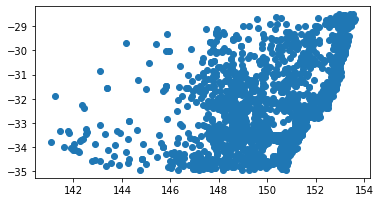

In [44]:
import json
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

with open('RFSStation_EPSG43267.json') as f:
  fire_stations = json.load(f)
f.close()


i = 0
data_length = len(fire_stations['RFSStation']['features'])
null_found = False

while i < data_length:
    if len(fire_stations['RFSStation']['features'][i]['geometry']['coordinates']) < 2:
        print("Null coordinates found")
        null_found = True
        
    i += 1

if not null_found:
    print("No Null Coordinates in this file. You're good to go!")
     
fireStation_df = gpd.GeoDataFrame.from_features(fire_stations['RFSStation'])
fireStation_df = fireStation_df.drop_duplicates(subset=['geometry'], keep='first')
fireStation_df.plot()

In [ ]:
from shapely.geometry import Point

gdf = geopandas.GeoDataFrame(d, crs="EPSG:4326")

In [46]:
neighbourhood_fire_prone = gpd.sjoin(neighbourhoods, rfs, op='contains')
neighbourhood_fire_prone= neighbourhood_fire_prone.drop(columns=['index_right'])
neighbourhood_fire_prone = neighbourhood_fire_prone.set_index('SA2_MAIN16')
neighbourhood_fire_prone

ValueError: 'left_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [31]:
neighbourhood_fire_prone = neighbourhood_fire_prone.set_crs(epsg=4326,allow_override=True )
fireStation_df = fireStation_df.set_crs(epsg=4326,allow_override=True ) 
join_neighbour_sa = join_neighbour_sa.set_crs(epsg=4326,allow_override=True 

area_with_stations = gpd.sjoin(sa2, fireStation_df, op='contains')
area_with_stations = area_with_stations.set_index('SA2_MAIN16')
area_with_stations = area_with_stations['geometry'].to_frame()
area_with_stations = area_with_stations.groupby(['SA2_MAIN16']).count()
area_with_stations

<ipython-input-31-01806432039e>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4283
Right CRS: None

  area_with_stations = gpd.sjoin(sa2, fireStation_df, op='contains')


,geometry
SA2_MAIN16,
101051539,2
101051540,32
101061541,1
101061542,13
101061543,5
...,...
128021535,3
128021537,2
128021607,1
